In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
device = 'mps'

In [4]:
class MyData(Dataset):
    def __init__(self, filepath):
        df = pd.read_csv(filepath, index_col=0)
        arr = df.values
        arr = arr.astype(np.float32)
        ts = torch.from_numpy(arr)
        ts = ts.to(device)
        self.X = ts[:, :-1]
        self.Y = ts[:, -1].reshape((-1, 1))
        self.len = ts.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [5]:
Data = MyData('Data.csv')
train_size = int(0.7 * len(Data))
test_size = len(Data) - train_size
train_data, test_data = random_split(Data, [train_size, test_size])

In [6]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [7]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 32), nn.Sigmoid(),
            nn.Linear(32, 8), nn.Sigmoid(),
            nn.Linear(8, 4), nn.Sigmoid(),
            nn.Linear(4, 1), nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

In [8]:
model = DNN().to(device)
model

DNN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [9]:
loss_fn = nn.BCELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

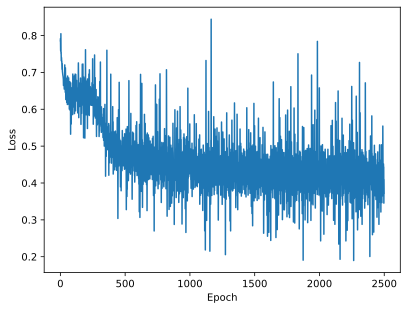

In [10]:
epochs = 500
losses = []

for epoch in range(epochs):
    for (x, y) in train_loader:
        Pred = model(x)
        loss = loss_fn(Pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [11]:
correct = 0
total = 0

with torch.no_grad():
    for (x, y) in test_loader:
        Pred = model(x)
        Pred[Pred >= 0.5] = 1
        Pred[Pred < 0.5] = 0
        correct += torch.sum((Pred == y).all(1))
        total += y.shape[0]
        
print('Accuracy: {:.2f}%'.format(100 * correct / total))

Accuracy: 76.75%
